In [10]:
from os import getcwd
from os.path import join, abspath

from copy import deepcopy
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from src.data.load_dataset import load_mnist, load_kmnist
from src.models.networks import V1_mnist_RFNet, classical_RFNet, V1_mnist_RFNet_ffc
from src.models.utils import train, test

In [3]:
data_dir = abspath(join(getcwd(), '../../'))
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [4]:
# load data
train_batch_size, train_percentage = 60000, 0.999
train_loader, val_loader, test_loader = load_kmnist(train_batch_size, train_percentage)

# training params
hidden_size = 1000
num_epochs = 30
num_trials = 5
log_interval = 1
lr = 1E-1
loss_fn = F.cross_entropy

compatible = {'s': 5, 'f':2}
incompatible = {'s': 10, 'f':18}

## V1 RFNet

In [ ]:
# declare model
s, f = compatible['s'], compatible['f']
scale = 2 / 784
model = V1_mnist_RFNet(hidden_size, s, f, center=None, scale=scale, seed=10).to(device)
model.v1_layer.weight.requires_grad = True

# declare optimizer and learning rate
optimizer = optim.SGD(model.parameters(), lr=lr)

# train and test
V1_train_loss = np.array([])
V1_test_error = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=True)
    test_err = test(model, device, test_loader, verbose=True)
    
    V1_train_loss = np.append(V1_train_loss, loss)
    V1_test_error[epoch] = test_err

## Classical Net

In [ ]:
## define the model
inp_size = (1, 28, 28)
scale = 2 / 784
model = classical_RFNet(inp_size, hidden_size, scale=scale).to(device)
model.RF_layer.weight.requires_grad = True

# define the optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# train and test
classical_train_loss = np.array([])
classical_test_error = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=True)
    test_err = test(model, device, test_loader, verbose=True)
    
    classical_train_loss = np.append(classical_train_loss, loss)
    classical_test_error[epoch] = test_err

In [ ]:
# plot the losses
fig = plt.figure(figsize=(12, 6))

num_batches = len(train_loader)
t = np.arange(len(train_loader) * num_epochs)
ax = fig.add_subplot(121)
plt.semilogy(t[::num_batches], V1_train_loss[::num_batches], '-', c='#2c7fb8')
plt.semilogy(t[::num_batches], classical_train_loss[::num_batches], '-', c='#d95f02')
plt.xlabel('Iterations')
plt.ylabel('Train loss')

t = np.arange(num_epochs)
ax = fig.add_subplot(122)
plt.plot(t, 100 - V1_test_error, '-o', c='#2c7fb8')
plt.plot(t, 100 - classical_test_error, '-o', c='#d95f02')
plt.xlabel('Epochs')
plt.ylabel('Test error')

### V1 RFNet with feedforward layers

In [198]:
# extract tensors from dataloader
train_batch_size, train_percentage = 1000, 0.999
train_loader, val_loader, test_loader = load_mnist(train_batch_size, train_percentage)
train_set, test_set = train_loader.dataset.dataset, test_loader.dataset
train, train_labels = train_set.data.float().to(device), train_set.targets.to(device)
test, test_labels = test_set.data.float().to(device), test_set.targets.float().to(device)

# mean subtract and convert to range of 0 and 1
X_train = (train - train.mean())/ train.std()
X_test = (test - test.mean())/ test.std()

# reshape dataset
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)

# params
hidden_size = 1000
num_epochs = 10000
num_trials = 5
log_interval = 1
lr = 1E-1
loss_fn = F.cross_entropy

In [209]:
# declare model
s, f = compatible['s'], compatible['f']
scale = 2 / 784
model = V1_mnist_RFNet(hidden_size, s, f, center=None, scale=scale, seed=None).to(device)
model.v1_layer.weight.requires_grad = True

# declare optimizer and learning rate
optimizer = optim.SGD(model.parameters(), lr=lr)

loss_list = []
test_accuracy = []
for i in range(num_epochs):
    optimizer.zero_grad()
    output = model(X_train.float())
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
#     print(loss)

In [211]:
output.shape

torch.Size([60000, 10])

In [200]:
pred = torch.argmax(model(X_test), axis=1)

In [201]:
torch.sum(pred == y_test) / 10000

tensor(0.9533, device='cuda:0')

(0.0, 2.0)

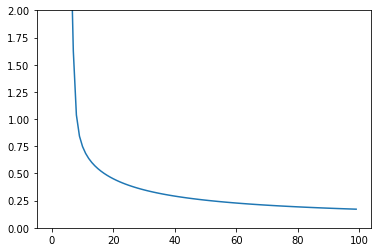

In [203]:
plt.plot(loss_list)
plt.ylim(0, 2)